In [1]:
#Importing all necessary modules
import os
from os import listdir
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm.notebook import tqdm_notebook, tnrange
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from PIL import Image

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [3]:
#Checking the number of images in the dataset
ids = next(os.walk("train/images"))[2]# list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  4000


In [4]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

#Initializing matrics for our images and masks

In [14]:
# tqdm is used to display the progress bar
# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for n, id_ in tqdm(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("train/images/"+id_, color_mode = "grayscale")
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = load_img("train/masks/"+id_, color_mode = "grayscale")
    mask = img_to_array(mask)
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    for a in mask :
        a[a>255.0]=255.0
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0
    #print(np.any(mask>255))

100%|██████████████████████████████████████| 4000/4000 [00:18<00:00, 212.61it/s]


In [15]:
print(X.shape,y.shape)

(4000, 128, 128, 1) (4000, 128, 128, 1)


In [17]:
# Split train and valid (test)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

Text(0.5, 1.0, 'Salt')

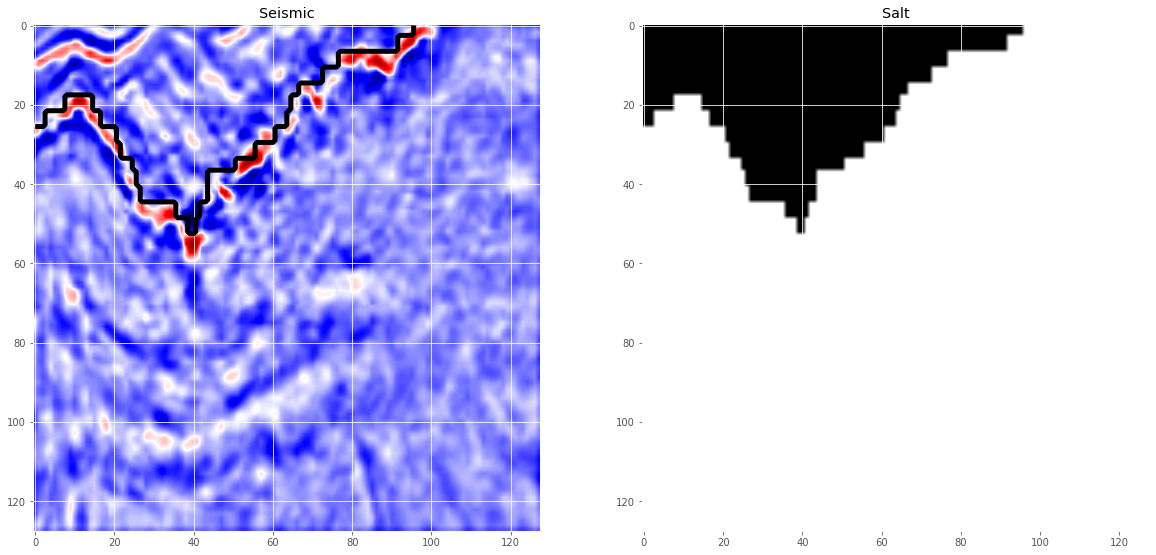

In [18]:
# Visualize any random image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
else:
  print("No salt")
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

not salt


Text(0.5, 1.0, 'Salt')

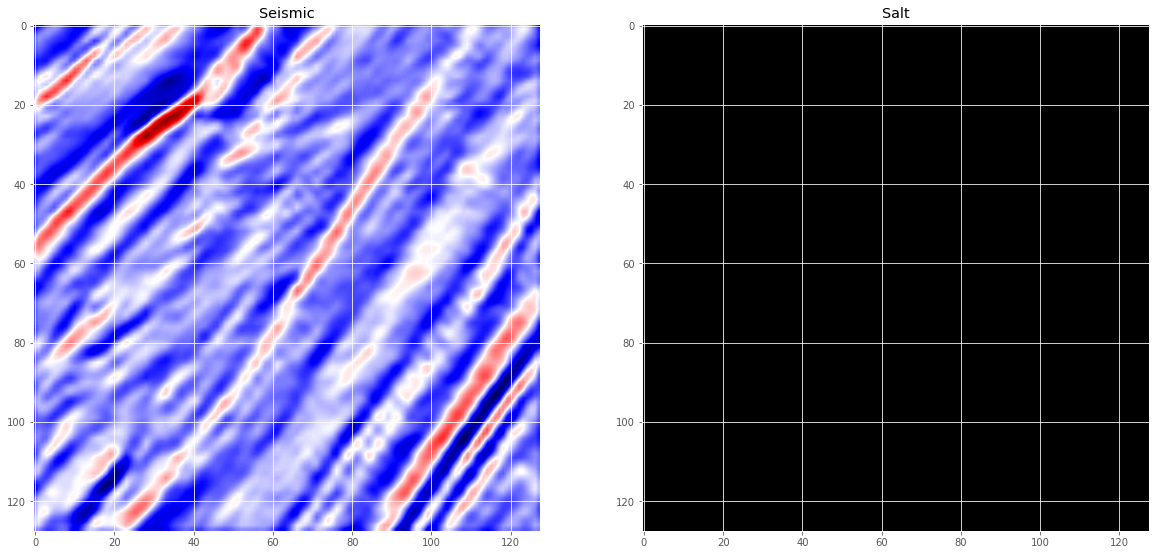

In [21]:

# Visualize any random image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
else:
  print("No salt")
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

In [20]:
# Convolution  => 2 layers
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x



In [22]:
#UNet Architecture 
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [23]:
#Using Adam optimizer and binary cross entropy loss
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

2022-09-06 16:09:39.862887: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [25]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

# Setting min learning rate and establishing early stopping

In [26]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/50
113/113 [==============================] - ETA: 0s - loss: 0.4085 - accuracy: 0.8379
Epoch 00001: val_loss improved from inf to 4.31085, saving model to model-tgs-salt.h5
113/113 [==============================] - 237s 2s/step - loss: 0.4085 - accuracy: 0.8379 - val_loss: 4.3108 - val_accuracy: 0.5817 - lr: 0.0010
Epoch 2/50
113/113 [==============================] - ETA: 0s - loss: 0.2952 - accuracy: 0.8881
Epoch 00002: val_loss did not improve from 4.31085
113/113 [==============================] - 225s 2s/step - loss: 0.2952 - accuracy: 0.8881 - val_loss: 7.0611 - val_accuracy: 0.4380 - lr: 0.0010
Epoch 3/50
113/113 [==============================] - ETA: 0s - loss: 0.2581 - accuracy: 0.9036
Epoch 00003: val_loss improved from 4.31085 to 2.85091, saving model to model-tgs-salt.h5
113/113 [==============================] - 218s 2s/step - loss: 0.2581 - accuracy: 0.9036 - val_loss: 2.8509 - val_accuracy: 0.6869 - lr: 0.0010
Epoch 4/50
113/113 [==============================

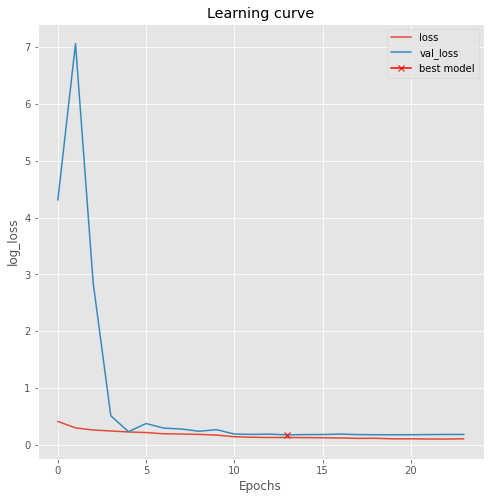

In [27]:
#plotting Learning curve ( log_loss vs epochs)
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [28]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [29]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

13/13 [==============================] - 4s 341ms/step - loss: 0.1728 - accuracy: 0.9284


[0.17278942465782166, 0.9284190535545349]

In [30]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

13/13 [==============================] - 5s 347ms/step


In [31]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [32]:
#Function for viewing plots and predictions
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

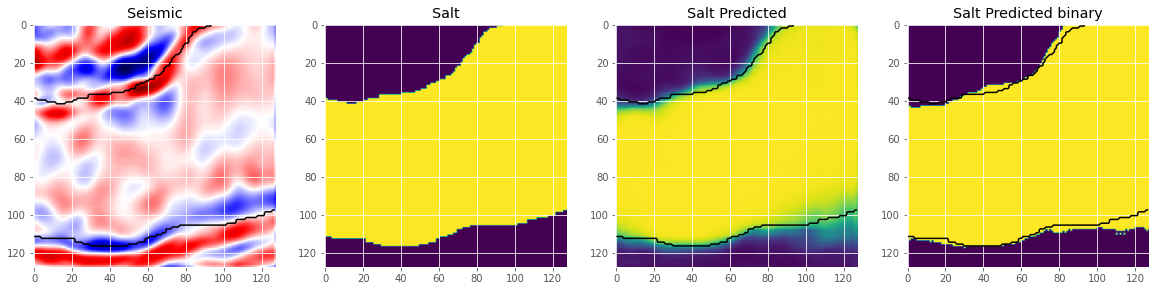

In [33]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

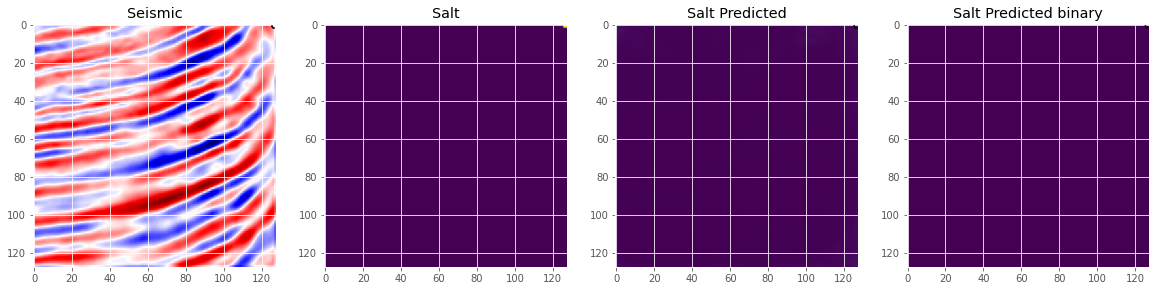

In [34]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

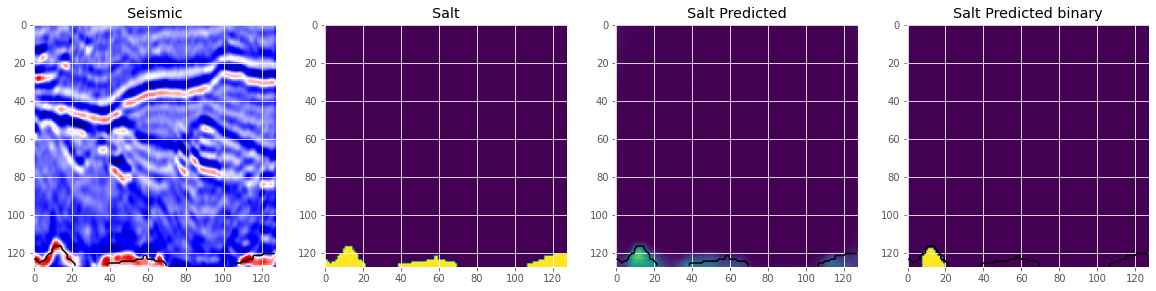

In [35]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

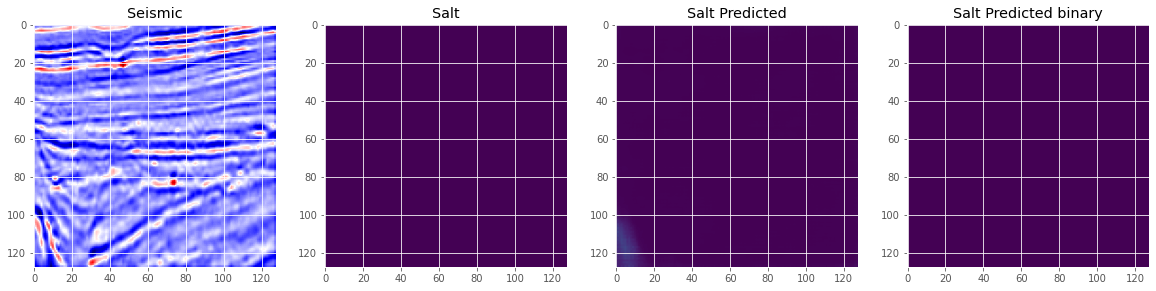

In [36]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

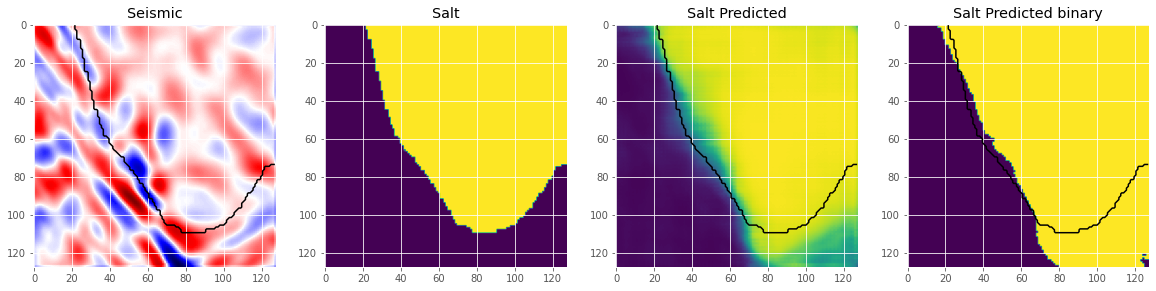

In [41]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

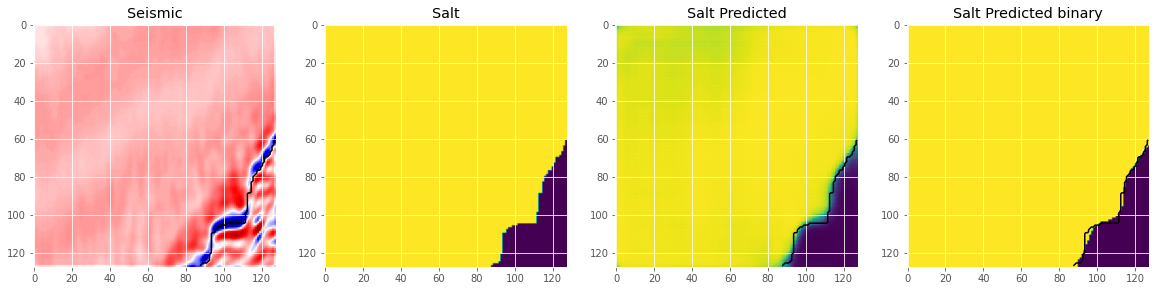

In [39]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

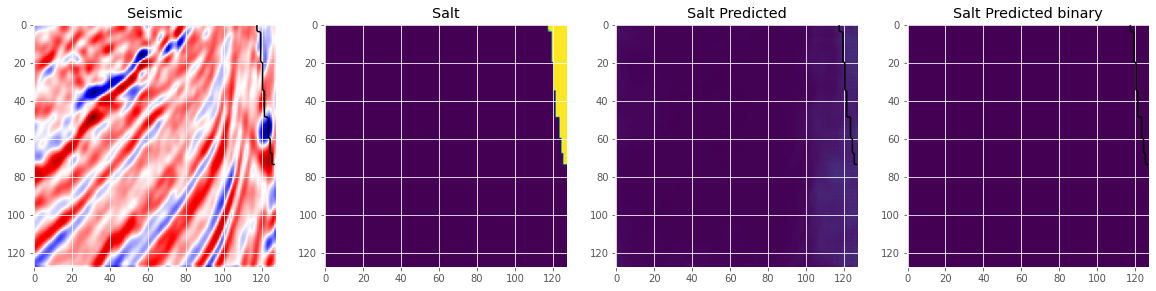

In [42]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)


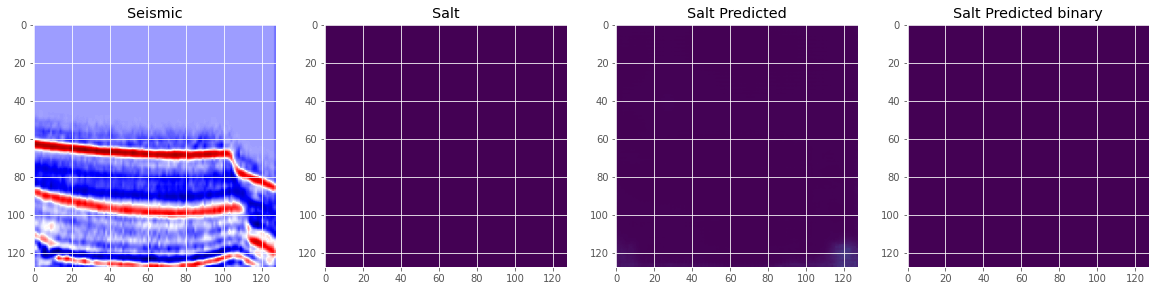

In [43]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

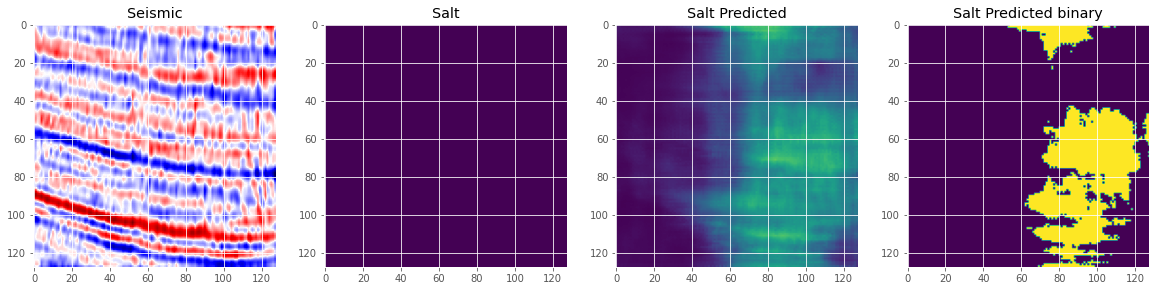

In [44]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

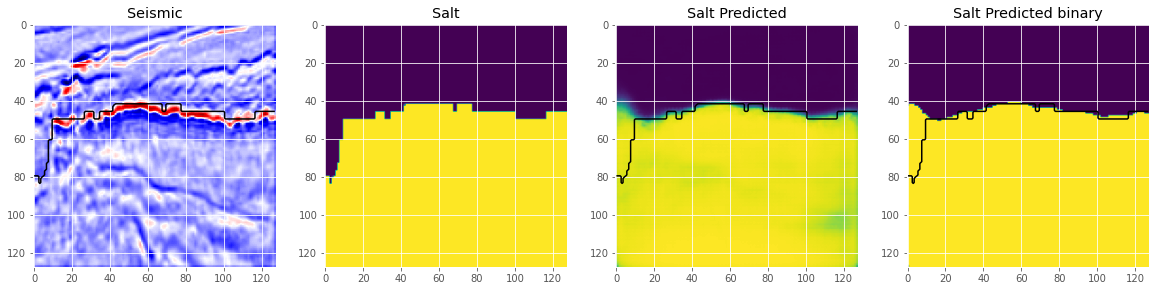

In [45]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

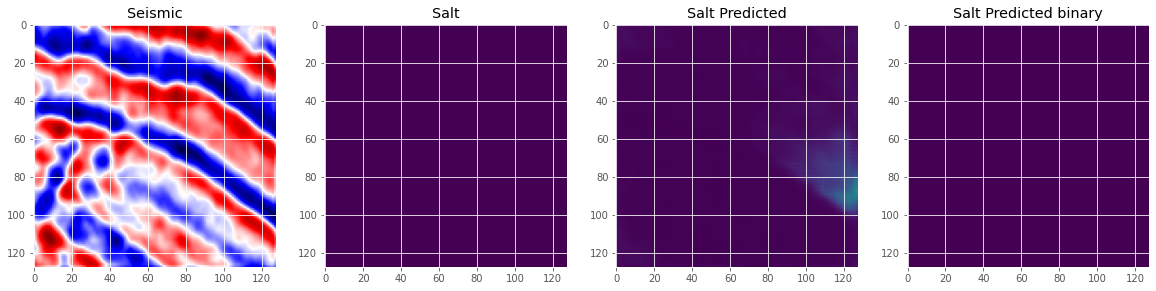

In [46]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

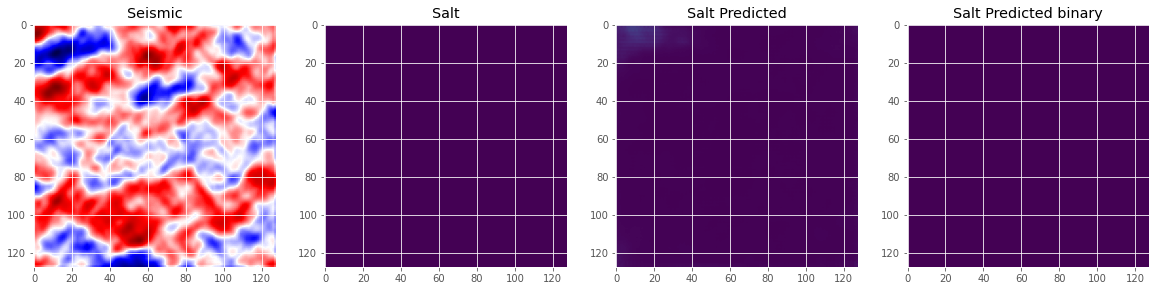

In [47]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

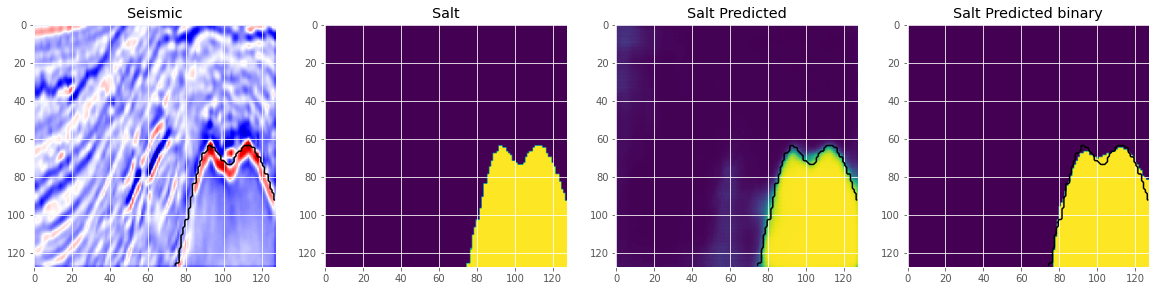

In [48]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)